In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import sqlite3

connection = sqlite3.connect("file:db/words.db?mode=ro")

In [107]:
username = 'stormalinblue'
user_id = connection.execute('select id from users where users.user_name = ?', (username,)).fetchone()[0]

In [108]:
import python_src.vocab_quiz.lib.game.model as gamemodel
from python_src.vocab_quiz.lib.common.util import utc_now_sec_timestamp

In [109]:
import pandas as pd
import numpy as np
import scipy

In [110]:
prior_correct = 0.25
prior_incorrect = 0.75
prior_total = prior_correct + prior_incorrect

word_weight_table = gamemodel.word_weight_table(
    connection,
    user_id,
    utc_now_sec_timestamp(),
    prior_correct=prior_correct,
    prior_incorrect=prior_incorrect)
word_pos_definitions = pd.read_sql(
    '''
select
    word_pos.id as word_pos_id, words.word as word, parts_of_speech.name as pos
from
    word_parts_of_speech as word_pos
    join words on words.id = word_pos.word_id
    join parts_of_speech on parts_of_speech.id == word_pos.part_of_speech_id
order by words.word, parts_of_speech.name''',
    con=connection,
    index_col=['word_pos_id']
)

word_table = pd.concat([word_pos_definitions, word_weight_table], axis=1)
print('num word pos', word_table.shape[0])

num word pos 524


                    word        pos    correct  incorrect  mean_prob
word_pos_id                                                         
306                blase  adjective  10.499225       0.75   0.933329
451          cyclothymia       noun  10.399526       0.75   0.932733
40                  coda       noun  10.291770       0.75   0.932076
345               frieze       verb  10.262763       0.75   0.931897
15              apposite       noun   9.958542       0.75   0.929962
49                cosset       noun   9.945648       0.75   0.929878
55             declivity       noun   9.877043       0.75   0.929425
57                 demur       verb   9.835267       0.75   0.929147
208             quixotic  adjective   9.799325       0.75   0.928905
149                knell       noun   9.758504       0.75   0.928629


Text(0.5, 1.0, 'PDFs for beta distributions for the top 10 words')

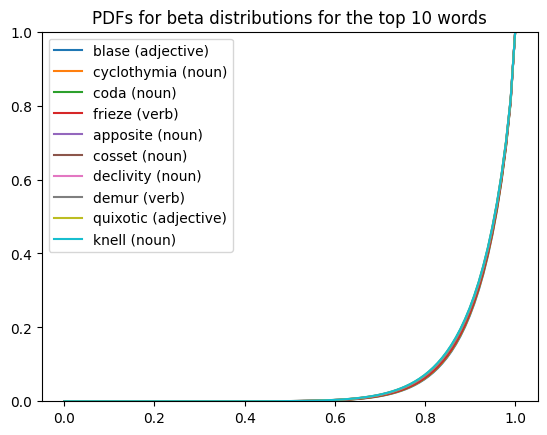

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x_axis = np.linspace(0, 1, 100)

n_highest = 10
word_table['mean_prob'] = (word_table['correct']) / (word_table['correct'] + word_table['incorrect'])
highest = word_table.sort_values('mean_prob', ascending=False).head(n_highest)
print(highest)
for word_pos_id, row in highest.iterrows():
    ax.plot(x_axis, scipy.stats.beta(row.correct, row.incorrect).cdf(x_axis), label=f'{row.word} ({row.pos})')

ax.set_ylim(0, 1)
ax.legend()
ax.set_title(f'PDFs for beta distributions for the top {n_highest} words')

                     word        pos    correct  incorrect  mean_prob
word_pos_id                                                          
110             fulminate       verb  10.438363   3.711106   0.737721
398              sedulous  adjective  13.518987   3.773246   0.781795
338               expiate       verb  16.437181   4.526481   0.784080
404               sinuous  adjective  16.246674   4.465019   0.784420
302          bacchanalian  adjective  12.359642   3.344251   0.787043
270                effete  adjective  10.999702   2.913622   0.790588
413                 stint       verb  18.422392   4.845858   0.791739
376            peremptory  adjective  16.550331   4.335003   0.792438
144              inveigle       verb  13.840561   3.590540   0.794015
314              churlish  adjective  32.044913   8.094773   0.798335


Text(0.5, 1.0, 'PDFs for beta distributions for the bottom 10 words')

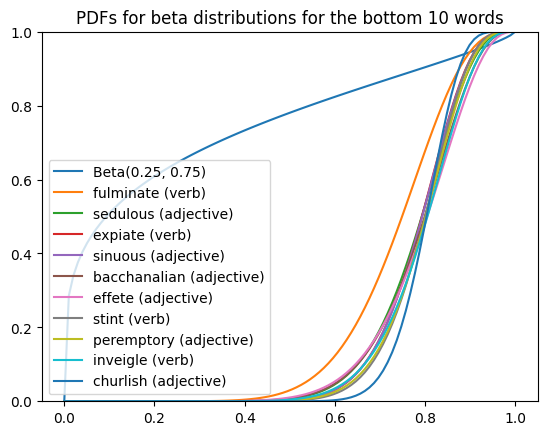

In [112]:
fig, ax = plt.subplots()
n_lowest = 10
lowest = word_table.sort_values('mean_prob', ascending=True).head(n_lowest)
print(lowest)
ax.plot(x_axis, scipy.stats.beta(prior_correct, prior_incorrect).cdf(x_axis), label=f'Beta({prior_correct}, {prior_incorrect})')
for word_pos_id, row in lowest.iterrows():
    ax.plot(x_axis, scipy.stats.beta(row.correct, row.incorrect).cdf(x_axis), label=f'{row.word} ({row.pos})')

ax.legend()
ax.set_ylim(0, 1)
ax.set_title(f'PDFs for beta distributions for the bottom {n_lowest} words')

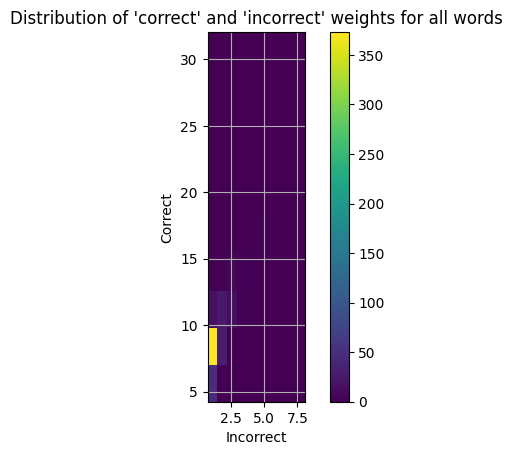

In [113]:
fig, ax = plt.subplots()

ax.set_xlabel('Incorrect')
ax.set_ylabel('Correct')
ax.set_title("Distribution of 'correct' and 'incorrect' weights for all words")
ax.grid(True)

mappable = ax.hist2d(word_table['incorrect'], word_table['correct'])
fig.colorbar(mappable[3], ax=ax)
ax.set_aspect(1)

Text(0, 0.5, 'Num words')

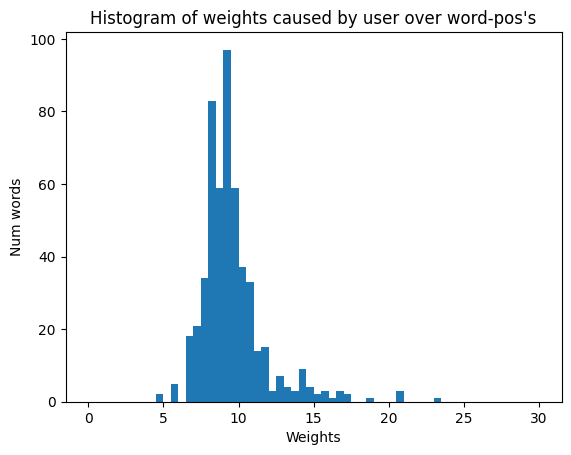

In [ ]:
fig, ax = plt.subplots()

ax.hist(word_table['correct'] + word_table['incorrect'], range=(0, 50), bins=50)
ax.set_title('Histogram of weights caused by user over word-pos\'s')
ax.set_xlabel('Weights')
ax.set_ylabel('Num words')

Text(0, 0.5, 'Number of words')

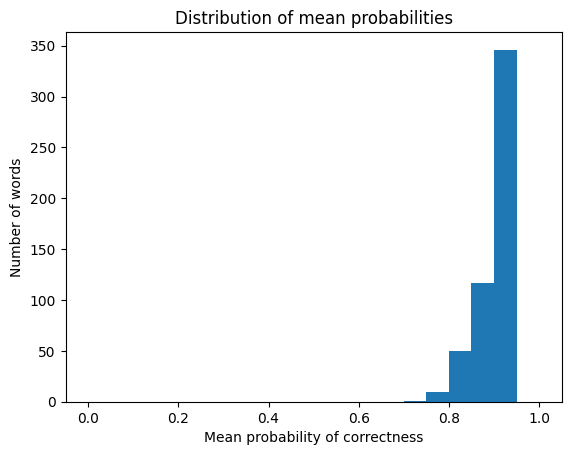

In [115]:
fig, ax = plt.subplots()

ax.hist(word_table['mean_prob'], range=(0, 1), bins=20)
ax.set_title('Distribution of mean probabilities')
ax.set_xlabel('Mean probability of correctness')
ax.set_ylabel('Number of words')

0.8402140687098365 0.9567526837887634 0.9903794164683418 0.9990457726647695


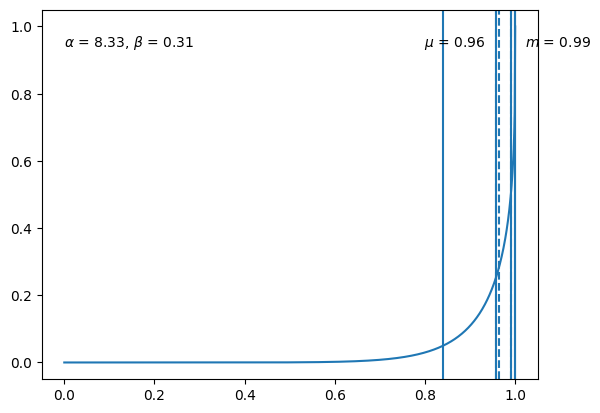

In [116]:
no_prior_word_table = gamemodel.word_weight_table(
    connection,
    user_id,
    utc_now_sec_timestamp(),
    prior_correct=0,
    prior_incorrect=0)
overall_incorrect = (no_prior_word_table['incorrect']).sum() / word_table.shape[0]
overall_correct = (no_prior_word_table['correct']).sum() / word_table.shape[0]

fig, ax = plt.subplots()
x_axis = np.linspace(0, 1, 1000)
overall_distribution = scipy.stats.beta(overall_correct, overall_incorrect)
ax.plot(x_axis, overall_distribution.cdf(x_axis))

median_prob = overall_distribution.median()
ax.axvline(median_prob, linestyle='--')
ax.annotate(
    text=f'$m$ = {median_prob:.02f}',
    xy=(median_prob, 0.9),
    xycoords=('data', 'axes fraction'),
    xytext=(10, 0),
    textcoords=('offset points'))
mean_prob = overall_distribution.mean()
ax.axvline(mean_prob, linestyle='--')
percentile_25 = overall_distribution.ppf(0.25)
ax.axvline(percentile_25, linestyle='--')
ax.annotate(
    text=f'$\\mu$ = {mean_prob:.02f}',
    xy=(mean_prob, 0.9),
    xycoords=('data', 'axes fraction'),
    ha='right',
    xytext=(-10, 0),
    textcoords=('offset points'))
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
for percentile in percentiles:
    pctile_value = overall_distribution.ppf(percentile)
    ax.axvline(pctile_value)
ax.annotate(
    text=f'$\\alpha$ = {overall_correct:.02f}, $\\beta$ = {overall_incorrect:.02f}',
    xy=(0, 0.9),
    xycoords=('data', 'axes fraction'))
print(overall_distribution.ppf(0.05), overall_distribution.ppf(0.25), overall_distribution.ppf(0.5), overall_distribution.ppf(0.75))

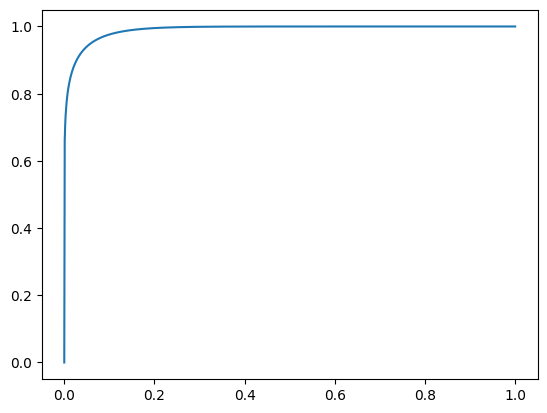

In [117]:
fig, ax = plt.subplots()
ax.plot(x_axis, scipy.stats.beta(0.1, 10).cdf(x_axis))